<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/DRL_single_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Trading

Tutorials to use OpenAI DRL to trade single stock in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



## Python Package Installation

As a first step we check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow

In [3]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4


     |████████████████████████████████| 5.5MB 3.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=7d89f66131cbb58f2c7444aa8bc8b6b9353689d8e78f8339f3f83724acd099bd
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 1.4MB 8.7MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074501 sha256=a07c9149b0e6ef809d06789949fd347417c7b2912b70d8440ca3e9cb5e3dd987
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 110.5MB 1.4MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |███████████████

## Import packages

In [4]:
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

# Part 1: Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.

In [6]:
# Download and save the data in a pandas DataFrame:
data_df = yf.download("AAPL", start="2009-01-01", end="2020-10-23")

[*********************100%***********************]  1 of 1 completed


In [7]:
data_df.shape

(2973, 6)

In [8]:
# reset the index, we want to use numbers instead of dates
data_df=data_df.reset_index()

In [9]:
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.800736,746015200
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.918938,1181608400
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.870794,1289310400
3,2009-01-07,3.278929,3.303571,3.223572,3.250357,2.808761,753048800
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.860918,673500800


In [10]:
data_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [11]:
# convert the column names to standardized names
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']

In [12]:
# save the data to a csv file in your current folder
#data_df.to_csv('AAPL_2009_2020.csv')

# Part 2: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.

In [13]:
# check missing data 
data_df.isnull().values.any()

False

In [14]:
# calculate technical indicators like MACD
stock = Sdf.retype(data_df.copy())
# we need to use adjusted close price instead of close price
stock['close'] = stock['adjcp']
data_df['macd'] = stock['macd']

In [15]:
# check missing data again
data_df.isnull().values.any()

False

In [16]:
data_df.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.800736,746015200,0.000000
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.918938,1181608400,0.002652
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.870794,1289310400,0.001886
3,2009-01-07,3.278929,3.303571,3.223572,3.250357,2.808761,753048800,-0.000748
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.860918,673500800,-0.000088


In [17]:
#data_df=data_df.fillna(method='bfill')

In [18]:
# Note that I always use a copy of the original data to try it track step by step.
data_clean = data_df.copy()

In [19]:
data_clean.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.800736,746015200,0.000000
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.918938,1181608400,0.002652
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.870794,1289310400,0.001886
3,2009-01-07,3.278929,3.303571,3.223572,3.250357,2.808761,753048800,-0.000748
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.860918,673500800,-0.000088


In [20]:
data_clean.tail()

,datadate,open,high,low,close,adjcp,volume,macd
2968,2020-10-16,121.279999,121.550003,118.809998,119.019997,119.019997,115393800,1.645568
2969,2020-10-19,119.959999,120.419998,115.660004,115.980003,115.980003,120639300,1.346273
2970,2020-10-20,116.199997,118.980003,115.629997,117.510002,117.510002,124423700,1.218491
2971,2020-10-21,116.669998,118.709999,116.449997,116.870003,116.870003,89946000,1.053437
2972,2020-10-22,117.449997,118.040001,114.589996,115.750000,115.750000,101988000,0.822772


# Part 3: Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [21]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

# Part 4: Implement DRL Algorithms
The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

### Training data: 2009-01-01 to 2018-12-31

In [22]:
train = data_clean[(data_clean.datadate>='2009-01-01') & (data_clean.datadate<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)

In [23]:
train.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.800736,746015200,0.000000
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.918938,1181608400,0.002652
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.870794,1289310400,0.001886
3,2009-01-07,3.278929,3.303571,3.223572,3.250357,2.808761,753048800,-0.000748
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.860918,673500800,-0.000088


### Model Training: 4 models, PPO A2C, DDPG, TD3

### Model 1: PPO

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_aapl_ppo")
#model.save('AAPL_ppo_100k')






Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




previous_total_asset:100000
end_total_asset:156098.18901026587
total_reward:56098.189010265865
total_cost:  6341.287377798898
total trades:  2491
Sharpe:  0.4187558739862496

previous_total_asset:100000
end_total_asset:94446.32340155944
total_reward:-5553.676598440565
total_cost:  2929.111106588759
total trades:  1887
Sharpe:  -0.4449912464199369
previous_total_asset:100000
end_total_asset:106926.53386862631
total_reward:6926.533868626313
total_cost:  5599.619928583559
total trades:  2210
Sharpe:  0.13181291830866868
previous_total_asset:100000
end_total_asset:210752.72119495703
total_reward:110752.72119495703
total_cost:  6167.86721222417
total trades:  2436
Sharpe:  0.5912451258666666
previous_total_asset:100000
end_total_asset:266216.10048735235
tot

### Model 2: DDPG

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
#model.save('AAPL_ddpg_50k')


previous_total_asset:100000
end_total_asset:381113.46135500714
total_reward:281113.46135500714
total_cost:  99.90638327732879
total trades:  2250
Sharpe:  0.7026063856823678
previous_total_asset:100000
end_total_asset:1080609.6161442325
total_reward:980609.6161442325
total_cost:  99.8974009731182
total trades:  2515
Sharpe:  1.0705602895308748
previous_total_asset:100000
end_total_asset:1080615.5633120066
total_reward:980615.5633120066
total_cost:  99.89794435650313
total trades:  2515
Sharpe:  1.0705613143272277
previous_total_asset:100000
end_total_asset:1080615.5633120066
total_reward:980615.5633120066
total_cost:  99.89794435650313
total trades:  2515
Sharpe:  1.0705613143272277
previous_total_asset:100000
end_total_asset:1080615.5633120066
total_reward:980615.5633120066
total_cost:  99.89794435650313
total trades:  2515
Sharpe:  1.0705613143272277
previous_total_asset:100000
end_total_asset:1080615.564949955
total_reward:980615.5649499551
total_cost:  99.89794448471066
total trade

### Model 3: A2C

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.learn(total_timesteps=100000,tb_log_name="run_aapl_a2c")
#model.save('AAPL_a2c_50k')



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
previous_total_asset:100000
end_total_asset:143568.45233873036
total_reward:43568.45233873036
total_cost:  6387.934081530226
total trades:  2456
Sharpe:  0.4585063869500929
previous_total_asset:100000
end_total_asset:471519.15020942007
total_reward:371519.15020942007
total_cost:  3212.7233202738003
total trades:  2510
Sharpe:  0.8100652990954699
previous_total_asset:100000
end_total_asset:711997.8256528199
total_reward:611997.8256528199
total_cost:  1962.9036105102316
total trades:  2509
Sharpe:  0.9281065879650406
previous_total_asset:100000
end_total_asset:813730.9830055628
total_reward:713730.9830055628
total_cost:  5242.129027291222
total trades:  2515
Sharpe:  0.9784477406469194
previous_total_asset:100000
end_total_asset:763906.3490314147
total_reward:663906.3490314147
total_cost:  4817.21023018733
total trades:  2513
Sharpe:  0.9614375402950348
previous_total_as

### Model 4: TD3

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
#model.save('AAPL_td3_50k')


previous_total_asset:100000
end_total_asset:778869.7048272111
total_reward:678869.7048272111
total_cost:  124.57847519610326
total trades:  2504
Sharpe:  0.9529387392421051
previous_total_asset:100000
end_total_asset:1080615.564949955
total_reward:980615.5649499551
total_cost:  99.89794448471066
total trades:  2515
Sharpe:  1.0705613146396975
previous_total_asset:100000
end_total_asset:1080615.564949955
total_reward:980615.5649499551
total_cost:  99.89794448471066
total trades:  2515
Sharpe:  1.0705613146396975
previous_total_asset:100000
end_total_asset:1080615.564949955
total_reward:980615.5649499551
total_cost:  99.89794448471066
total trades:  2515
Sharpe:  1.0705613146396975
previous_total_asset:100000
end_total_asset:1080615.564949955
total_reward:980615.5649499551
total_cost:  99.89794448471066
total trades:  2515
Sharpe:  1.0705613146396975
previous_total_asset:100000
end_total_asset:1080615.564949955
total_reward:980615.5649499551
total_cost:  99.89794448471066
total trades:  

### Testing data

In [ ]:
test = data_clean[(data_clean.datadate>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [ ]:
test.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,38.629097,148158800,-2.023387
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.781353,365248800,-2.206829
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.266144,234428400,-2.206957
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.185429,219111200,-2.188346
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.875229,164101200,-2.093799


### Trading
Assume that we have $100,000 initial capital at 2019-01-01. We use the TD3 model to trade AAPL.

In [ ]:
model = model_td3
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:310696.8490824127
total_reward:210696.84908241272
total_cost:  99.87627464294434
total trades:  456
Sharpe:  1.864143095949389


# Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [ ]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [ ]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [ ]:
df_total_value=get_DRL_sharpe()

annual return:  100.59183078922125
sharpe ratio:  1.8641430959493877


In [ ]:
get_buy_and_hold_sharpe(test)

annual return:  97.36192520498028
sharpe ratio:  1.7753353475308546


In [ ]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1

In [ ]:
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

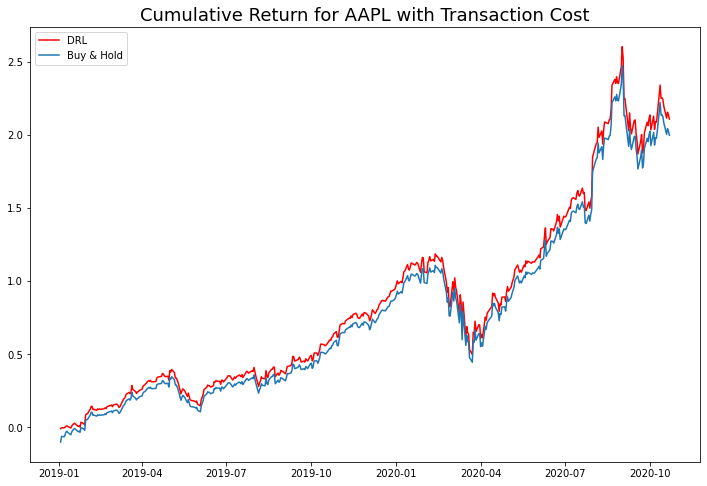

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
